In [1]:
import pickle
import sys
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
from get_time_interval_matrix_data import get_time_interval_matrix_data
from PCA import get_cdata
from PCA import get_eigen_vectors
from PCA import project_to_eigen_vectors
from Plot import plot_data
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Step 1: Train model on 29th and 30th September

In [2]:
training_data = get_time_interval_matrix_data('Sep 29 2020 11:00AM', 'Sep 30 2020 05:00PM')

In [3]:
eigen_values_2930, eigen_vectors_2930 = get_eigen_vectors(training_data)

/home/ardelalegre/SoundMapping/Analysis/Util/PCA.py:44: RuntimeWarning: Mean of empty slice
  data_mean = np.nanmean(data[:,1:],axis = 0,keepdims = True)


### Step 2: Extract 10 points experiment data from recent 10 point experiment. Subtract mean and replace nans with 0s.

In [4]:
experiment_data = get_time_interval_matrix_data('Sep 30 2020 11:10AM', 'Sep 30 2020 11:20AM')

In [5]:
experiment_cdata = get_cdata(experiment_data)

### Step 3: Project this data onto the eigenvectors just trained.

### Let d be the number of PCA coordinates we choose to train our model with

In [50]:
d = 3

In [51]:
"""
projects data to eigen vectors

@param numpyArray cdata - data set to project to eigen vectors
@param int dimensions - number of eigen vectors to project data onto

if optional params are not set, default will be taken from values.py
@optionalParam numpyArray eigen_values - array of eigen values
@optionalParam numpyArray eigen_vectors - array of eigen vectors

@return numpyArray data projected onto eigen vectors
"""


proj_exp_data = project_to_eigen_vectors(experiment_cdata, d, eigen_values_2930, eigen_vectors_2930)


Take time averages: Each row is a position in the PCA space. For the first 40 seconds of each minute, we want just one row.

In [52]:
print("The projected data is of shape", proj_exp_data.shape,"and the experiment data is of the shape", experiment_data.shape)

The projected data is of shape (64665, 3) and the experiment data is of the shape (64665, 19)


In [53]:
def extractMinuteData(i):
    """Input: int, index of minute, ranging from 0 to 9
       Output: numpy array, relevant data corr. to minute"""
    # making a list of numpy arrays that store the first three projections for each minute
    # our list will have 10 entries - one for each minute

    # we project our mean centered data onto the first three eigenvectors
#     first_three_projections = np.dot(cdata,sorted_eigvec[:,:3])



    # 1. extracting first entry of list below

    format_timestring = '%b %d %Y %I:%M:%S%p' # setting format of input time
    start_timestring = 'Sep 30 2020 11:1' + str(i) +':00AM' # setting start time
    end_timestring = 'Sep 30 2020 11:1' + str(i) + ':40AM' # setting end time
    start_standard_dt_string = datetime.datetime.strptime(start_timestring, format_timestring) # converting start time into datetim
    end_standard_dt_string = datetime.datetime.strptime(end_timestring, format_timestring) # converting end time into datetime object


    # given the starting and ending timestamps, we map them to indices of the data so that
    # we know our time of interest in terms on indices

    for x in range(experiment_data.shape[0]):
        if(experiment_data[x,0] > datetime.datetime.timestamp(start_standard_dt_string) and experiment_data[x,0] < datetime.datetime.timestamp(end_standard_dt_string)):
            start_index = x
            break
    for y in range(x,experiment_data.shape[0]):
        if(experiment_data[y,0] > datetime.datetime.timestamp(end_standard_dt_string)):
            end_index = y
            break

    # given the range of indices which correspond to the input time, we extract the relevant data from
    # first_three_projections and returning
    relevant_data_minute = proj_exp_data[x:y]
    
    return relevant_data_minute

In [54]:
minute_arrays = [] # creating empty list where we will store 10 elements, each of which contains 1 minute data
for i in range(10): # where i is minute
    one_minute_data = extractMinuteData(i)
    minute_arrays.append(one_minute_data)

In [55]:
minute_mean_array = [np.mean(i,axis = 0) for i in minute_arrays]
minute_mean_array_np = np.asarray([np.mean(i,axis = 0) for i in minute_arrays])
minute_mean_array_np

array([[ 0.05822214, -0.00797179,  0.27806983],
       [-0.32255706, -0.39739336, -0.22195283],
       [-0.16200351, -1.08790654,  0.07445783],
       [ 0.49177874, -0.63193515, -0.01310243],
       [ 0.49622844, -0.31707096,  0.3743973 ],
       [ 0.9332747 ,  0.56002251,  0.16896752],
       [ 0.26446337,  1.06140409, -0.00474484],
       [-0.56423322,  0.8989157 , -0.04060002],
       [-1.03231139,  0.17344205, -0.26140588],
       [-0.0713117 ,  0.16830789, -0.02724228]])

### Obtain physical (x, y) positions of all points 0 to 9

In [56]:
p_0 = [0,0]
p_1 = [1.2,-0.6]
p_2 = [0,-0.6]
p_3 = [-1.2,-0.6]
p_4 = [1.2,0.6]
p_5 = [0,0.6]
p_6 = [-1.2,0.6]
p_7 = [1.2,1.8]
p_8 = [0,1.8]
p_9 = [-1.2,1.8]

list_phys_all_pt_coords = [p_0, p_1, p_2, p_3, p_4, p_5, p_6, p_7, p_8, p_9]

In [57]:
phys_all_pt_coords = np.asarray(list_phys_all_pt_coords)
print(phys_all_pt_coords)

[[ 0.   0. ]
 [ 1.2 -0.6]
 [ 0.  -0.6]
 [-1.2 -0.6]
 [ 1.2  0.6]
 [ 0.   0.6]
 [-1.2  0.6]
 [ 1.2  1.8]
 [ 0.   1.8]
 [-1.2  1.8]]


### Setup

* Room coordinates : $\vec{r}_i$ for $i=1:n$ $\vec{r}_i \in R^2$
* PCA coordinates : $\vec{v}_i$ for $i=1:n$ $\vec{v}_i \in R^{18}$

We choose $d$ the number of PCA coordinates to use. Probably $d=2,3$

We want an affine transformation which can be described by a matrix and a shoft vector.

$\vec{r} = \vec{s} + M \vec{v}$  where $\vec{s}$ is a 2 dimensional shift, and $M$ is a $2 \times d$ matrix

We can add a coordinate equal to $1$ to the vector $\vec{v}$ (call it $\vec{w}$) and add a column equal to $\vec{s}$ to the matrix $M$ (call is $G$)

Now we have an expressions of the form 

$ \vec{r}_i = G \vec{w}_i$

### Solving

The $2(d+1)$ entries of $G$ the unknowns.

If $2(d+1) > n$ then we have an under-constrained system (there is an infinite number of solutions)

Define the regularization term $\|G\|$ as the sum of the squares of all entries in $G$.

If $2(d+1) < n$ then there is no solution (in general).

We can replace the equalities $ \vec{r}_i = G \vec{w}_i$ by an error:
$$\sum_i \| \vec{r}_i - G \vec{w}_i\|_2^2 $$

Combining this with the regularization term, we get

$$err(G) = \sum_i \| \vec{r}_i - G \vec{w}_i \|_2^2 + \|G\|$$ 

and our goal is to find $G$ with the minimal error.

$$
G = 
\begin{bmatrix}
G_{1,1} & G_{1,2} & \cdots & G_{1,{d+1}} \\
G_{2,1} & G_{2,2} & \cdots & G_{2,{d+1}}
\end{bmatrix}
$$

We find that the optimization of $err(G)$ can be written as two independent optimizations:
$$err_x(G) =  \sum_i \left( \begin{bmatrix}
G_{1,1} & G_{1,2} & \cdots & G_{1,{d+1}}
\end{bmatrix}
\vec{w}_i^T -\vec{r}_{i,1}
\right)^2 $$

$$err_y(G) =  \sum_i \left( \begin{bmatrix}
G_{2,1} & G_{2,2} & \cdots & G_{2,{d+1}}
\end{bmatrix}
\vec{w}_i^T -\vec{r}_{i,2}
\right)^2 $$

As the variables to be optimized for each error (the $G_i's$) are disjoint, each of $err_x,err_y$ can be optimized indpendently. 

### Defining matrices

$R$ should be a matrix consisting of all physical coordinates $r$ 

In [58]:
R = phys_all_pt_coords

Similarly, $W$ should be a matrix with all the d dimensional PCA points with a 1 appended to it.

In [59]:
part_W = minute_mean_array_np.T
ones = np.asarray([1.0 for i in range(10)])
W = np.vstack((part_W, ones))

### Model X

In [60]:
model_a_Y = R[:,0]
model_a_Y = np.reshape(model_a_Y,(10,1))
model_a_X = W.T
param_x = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y)

In [61]:
param_x

array([[-1.04126802],
       [-0.06492261],
       [ 2.52852803],
       [-0.07038506]])

### Model Y

In [62]:
model_a_Y_2 = R[:,1]
model_a_Y_2 = np.reshape(model_a_Y_2,(10,1))
model_a_X = W.T
param_y = np.dot(np.dot(np.linalg.inv(np.dot(model_a_X.T, model_a_X)), model_a_X.T), model_a_Y_2)

In [63]:
G = np.stack((param_x.T, param_y.T))
G = np.reshape(G, (2, d+1))
G

array([[-1.04126802, -0.06492261,  2.52852803, -0.07038506],
       [-0.96246129,  1.00265557,  1.22825869,  0.46657353]])

### Transforming PCA points using Linear Regression Matrix G

In [64]:
# append column of 1's to proj_exp_data

one_long = np.ones((64665,1))
to_project_mat = np.hstack((proj_exp_data, one_long))
to_project_mat_correct_orientation = to_project_mat.T
projected_mat = G @ to_project_mat_correct_orientation

In [65]:
# model_a_X contains mean points from PCA space
model_a_X
# premultiply this with G
transformed_mean_points = G @ model_a_X.T
transformed_mean_points.shape


(2, 10)

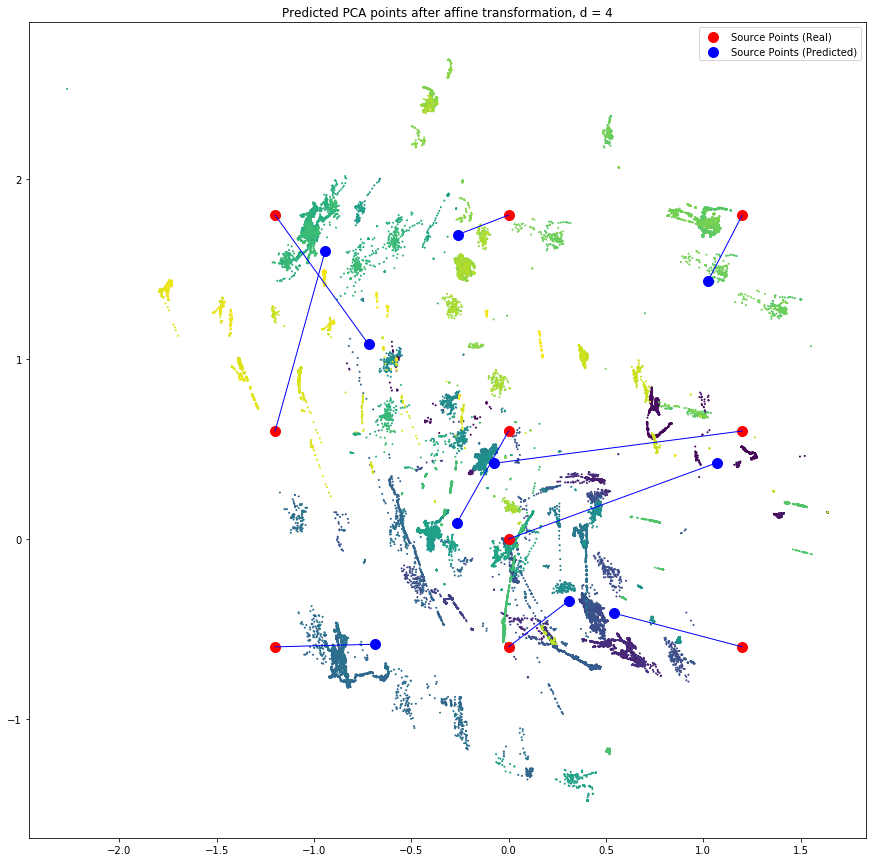

In [49]:
# plot d = 4
fig = plt.figure(figsize= (15,15))
ax = fig.add_subplot(111)
ax.scatter(projected_mat[0,:], projected_mat[1,:], s = 1, c = np.arange(64665))
ax.scatter(R[:,0], R[:,1],s = 100, c = 'r', label='Source Points (Real)')
ax.scatter(transformed_mean_points[0,:], transformed_mean_points[1,:], s = 100, c = 'b', label='Source Points (Predicted)')
for i in range(10):
    ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
ax.set_title('Predicted PCA points after affine transformation, d = 4')
ax.legend();

In [82]:
# sanity check

point_initial = model_a_X[0,:]
print(point_initial)
point_final = transformed_mean_points[:,0]
print(point_final)
G @ point_initial

[ 0.05822214 -0.00797179  0.27806983  1.        ]
[0.57261499 0.7440857 ]


array([0.57261499, 0.7440857 ])

In [78]:
W.shape, point_initial.shape

((4, 10), (4,))

In [73]:
model_a_X

array([[ 0.05822214, -0.00797179,  0.27806983,  1.        ],
       [-0.32255706, -0.39739336, -0.22195283,  1.        ],
       [-0.16200351, -1.08790654,  0.07445783,  1.        ],
       [ 0.49177874, -0.63193515, -0.01310243,  1.        ],
       [ 0.49622844, -0.31707096,  0.3743973 ,  1.        ],
       [ 0.9332747 ,  0.56002251,  0.16896752,  1.        ],
       [ 0.26446337,  1.06140409, -0.00474484,  1.        ],
       [-0.56423322,  0.8989157 , -0.04060002,  1.        ],
       [-1.03231139,  0.17344205, -0.26140588,  1.        ],
       [-0.0713117 ,  0.16830789, -0.02724228,  1.        ]])

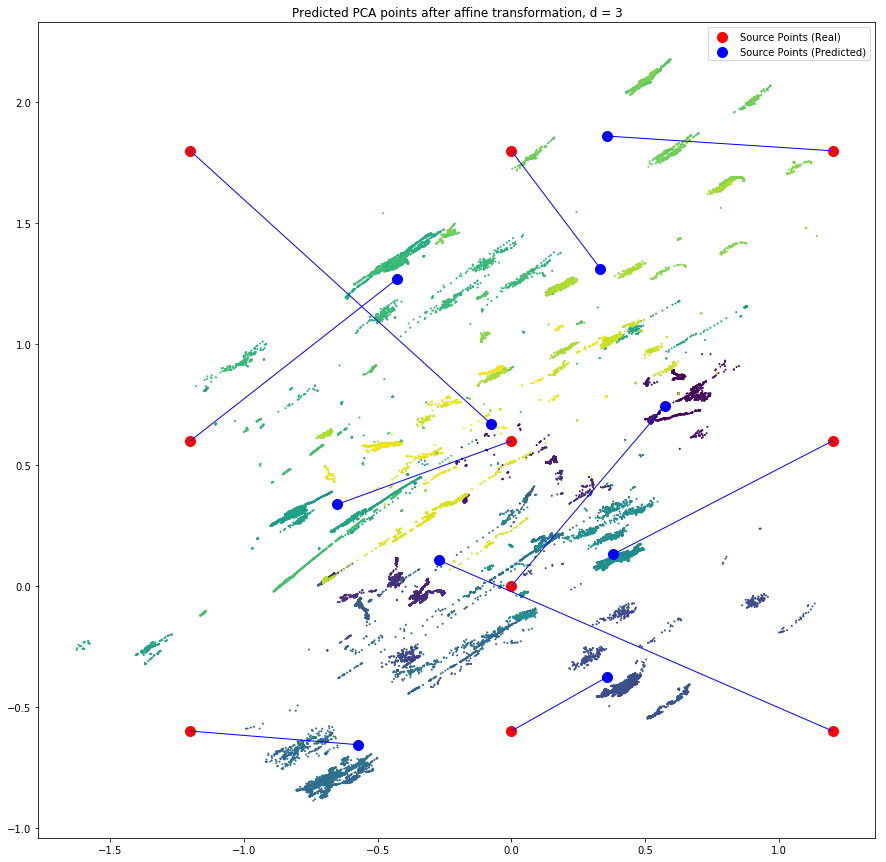

In [66]:
# plot d = 3
fig = plt.figure(figsize= (15,15))
ax = fig.add_subplot(111)
ax.scatter(projected_mat[0,:], projected_mat[1,:], s = 1, c = np.arange(64665))
ax.scatter(R[:,0], R[:,1],s = 100, c = 'r', label='Source Points (Real)')
ax.scatter(transformed_mean_points[0,:], transformed_mean_points[1,:], s = 100, c = 'b', label='Source Points (Predicted)')
for i in range(10):
    ax.plot([R[i,0], transformed_mean_points.T[i,0]], [R[i,1],transformed_mean_points.T[i,1]], linewidth=1, c = 'blue')
ax.set_title('Predicted PCA points after affine transformation, d = 3')
ax.legend();

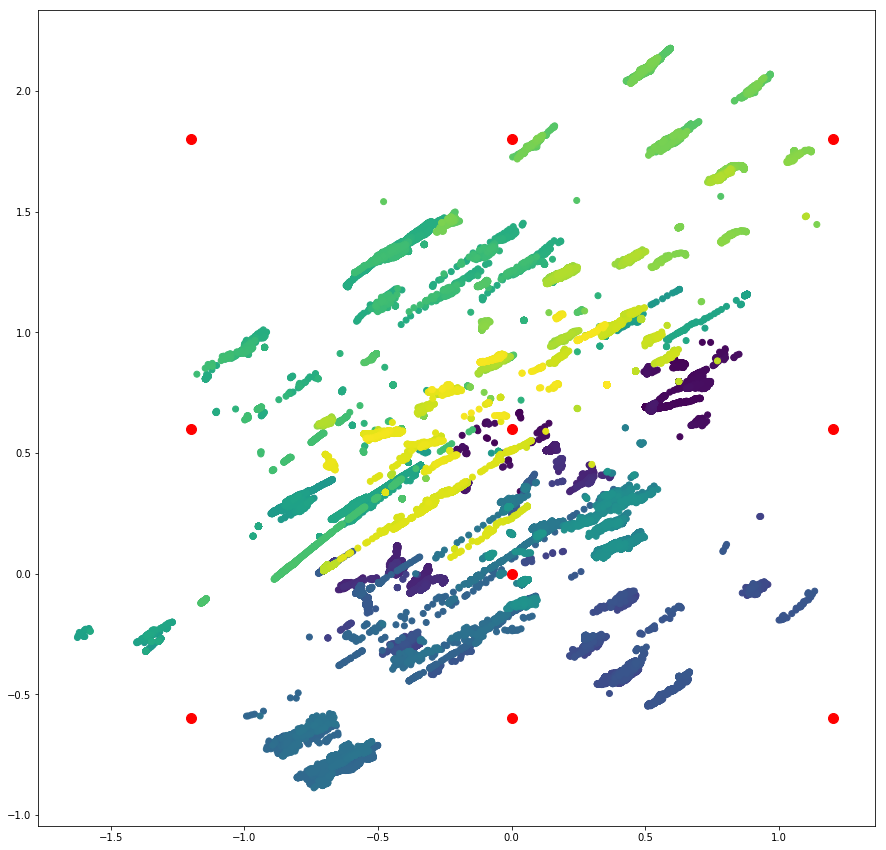

In [92]:
# plot d = 3
fig = plt.figure(figsize= (15,15))
ax = fig.add_subplot(111)
ax.scatter(projected_mat[0,:], projected_mat[1,:], c = np.arange(64665))
ax.scatter(R[:,0], R[:,1],s = 100, c = 'r')

Things to try:
1. Two PCA components
2. Using something other than mean? Mode?